# Homework 4

### start by reading in the four starting images

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import isclose

# unzip the faces.zip file into the folder containing Homework4.ipynb

# path to faces - need to reformat to work with your computer and operating system
path = './faces/'

# read in the four starting images
fisher   = plt.imread(path+'fisher.png')
stewart  = plt.imread(path+'stewart.png')
obama    = plt.imread(path+'obama.png')
cranston = plt.imread(path+'cranston.png')

# store the four faces in a list
# list with the 4 image matrices
face = [fisher, stewart, obama, cranston]
fnames = ['Fisher', 'Stewart', 'Obama', 'Cranston']
n_faces = len(face)

(fx, fy) = fisher.shape
flen = fx*fy
print('image size : ', fx, fy)

image size :  32 32


### view images

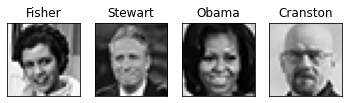

In [2]:
# view the four faces
for i in range(n_faces):
    plt.subplot(1, 4, i+1)
    plt.imshow(face[i], 'gray')
    plt.tick_params(axis='both', which='both',
                    bottom=False, top=False, labelbottom=False, 
                    right=False, left=False, labelleft=False)  
    plt.title(fnames[i])
plt.show()

### check image properties (values and types)

In [3]:
print('min pixel val of fisher : ', np.min(fisher))
print('max pixel val of fisher : ', np.max(fisher))
print('type in pixel : ', type(fisher[0,0]))

min pixel val of fisher :  0.0
max pixel val of fisher :  1.0
type in pixel :  <class 'numpy.float32'>


### center image around 0 and reshape into a 1D array rather than a 2D array

In [4]:
# preallocate numpy array to hold vectors of the four images
pats = np.zeros([n_faces, flen])

for i in range(n_faces):
    # reshape image
    p = face[i].reshape((flen,))
    
    # turn each image into a pattern ranging [-1 1]
    # Recentering about 0
    pats[i, :] = (p*2)-1
    
    # normalize each pattern to be unit length
    pats[i, :] = pats[i, :] / np.linalg.norm(pats[i, :])

### create noisy versions of each face to train network

In [5]:
import numpy.random as r

# create noisy versions of the image patterns 
n_train = 500

# amount of noise, width (e.g. std) of the normal distribution of noise added
noise_scale = 0.07

# preallocate training pattern array
train_pats = np.zeros([n_train*n_faces, flen]) #e.g. 2000 x 1024

idx = 0
# create noisy training patterns
# For each of the 500 variations, we will do the 4 faces we have
for j in range(n_train):
    for i in range(n_faces):
        
        # normal noise with 0 mean and stdev of 1, multiplied by noise_scale (0.07 std)
        unit_noise = r.randn(flen)*noise_scale
        # ^E.g. end up with a norm dist centered around 0, std of 0.07
        
        # add face with noise to produce training data
        train_pats[idx, :] = pats[i, :] + unit_noise
        
        # normalize activation to unit length
        train_pats[idx, :] = train_pats[idx, :] / np.linalg.norm(train_pats[idx, :])
        
        idx += 1

### display some of the noisy training patterns

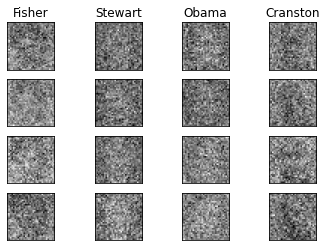

In [6]:
# you can play around with decreasing the noise level

for i in range(16):
    plt.subplot(4, 4, i+1)
    
    # reshape to square image
    this = train_pats[i, :].reshape([fx, fy])
    
    # convert back to [0 1] range
    this = (this+1)/2
    
    plt.imshow(this,'gray')
    
    plt.tick_params(axis='both',which='both',
          bottom=False,top=False,labelbottom=False,right=False,left=False,labelleft=False)   
    if i < 4:
        plt.title(fnames[i])

<hr>

<b>Q1.</b> Create a new 2000x4 numpy array called train_outs that has the “teacher” (output values you are training the network to reproduce) for each training pattern. For now, have the output of the correct answer equal to 1 and of the incorrect answers equal to 0.

Remember: You must not use hard-coded values. I have defined a lot of variables earlier in the code that you should use in your code.

In [7]:
### enter Q1 answer here ###

def my_reverse(lst):
    return [ele for ele in reversed(lst)]

train_outs = np.zeros((n_train*n_faces, n_faces))

for i in range(n_train*n_faces):
    train_outs[i,i%4] = 1

In [8]:
# "Unit testing"

print(train_outs.shape)
for my_row in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:
    print(f"Row {my_row}: {train_outs[my_row,:]}")

(2000, 4)
Row 0: [1. 0. 0. 0.]
Row 1: [0. 1. 0. 0.]
Row 2: [0. 0. 1. 0.]
Row 3: [0. 0. 0. 1.]
Row 4: [1. 0. 0. 0.]
Row 5: [0. 1. 0. 0.]
Row 6: [0. 0. 1. 0.]
Row 7: [0. 0. 0. 1.]
Row 8: [1. 0. 0. 0.]
Row 9: [0. 1. 0. 0.]
Row 10: [0. 0. 1. 0.]
Row 11: [0. 0. 0. 1.]
Row 12: [1. 0. 0. 0.]


<hr>

<b>Q2.</b> Create a weight matrix with the appropriate dimensions. Initialize the weights in the matrix to random numbers drawn from a normal distribution. Normalize the weights so that the vector of weights contributing to the net input of any given output node has length equal to 1.

In [9]:
### enter Q2 answer here ###

# Note: assume linear activation function
rng = np.random.default_rng(12345)
W = rng.random((fx*fy, n_faces))  # 1024, 4 (e.g. inputs, outputs)

for k in range(n_faces):
        W[:, k] = W[:, k] / np.linalg.norm(W[:, k])

In [10]:
# "Unit testing"

print(W.shape)
for face in range(n_faces):
    print(np.linalg.norm(W[:, face]))
    #assert isclose(sum(W[0,:]), 1)

(1024, 4)
1.0
0.9999999999999999
0.9999999999999999
1.0


<hr>

<b>Q3.</b> Train the network using Oja’s rule. As described in class, tor each of the 2000 patterns, the change in weight $Δw_{ij}$ between input node $i_{i}$ and output node $o_{j}$ is given by

$Δw_{ij} = λ \, i_{i} \, o_{j}$

where λ is the learning rate (assume λ = .01). If you stopped here, this would be Hebbian learning. For Oja’s rule, you will need to normalize the weights after updating the weights for each training pattern such that the vector of weights contributing to the net input of any given output node has length equal to 1 (you don’t normalize after every individual Δ$w_{ij}$ update, but after you update all the weights in the network).

Obviously, to train the network, you will need to write code to train the network. In Homework 3, we gave you Keras code to do the training. For this assignment, you need to write that training code from scratch. This should be only a few lines of code. It’s not complicated.

You do not need to worry about making your code efficient (vectorizing and the like) – you can if you want, but you do not have to. Slow is fine, so long as it runs correctly. Note that it will take a while to train the network (several minutes, depending on the speed of your computer). 

In [11]:
### enter Q3 answer here ###
# Have to do this by hand, cannot do this via keras/tf
# Step through all of the weights and adjust them as you go
# Do all the weight updates first for a given pattern
# oj is the teacher that is clamped onto the output
# You CANNOT do Hebbian learning with Keras/Tensorflow. 
# You need to implement Oja's rule (Hebbian learning + weight normalization) using basic Python code. 

lr = 0.01

for i in range(n_train*n_faces):
    for j in range(fx*fy):  # Num pixels
        for k in range(n_faces):  # Num faces
            dw = lr*train_pats[i,j]*train_outs[i,k]
            # The rule given in the slides for Oja's Rule
            # dwij = lr*(ii*oj-oj**2*wij)
            # dw = lr * (train_pats[i,j]*train_outs[i,k] - W[j,k]*train_outs[i,k]**2)
            W[j,k] += dw
            
    # Oja's Rule: Normalize before the next pattern is presented
    # Normalize the weights
    # normalize activation to unit length
    for k in range(n_faces):
        W[:, k] = W[:, k] / np.linalg.norm(W[:, k])

In [12]:
# "Unit testing"

print(W.shape)
for face in range(n_faces):
    print(np.linalg.norm(W[:, face]))
    #assert isclose(sum(W[0,:]), 1)

(1024, 4)
1.0
1.0
1.0
0.9999999999999999


<hr>

<b>Q4.</b> Visualize the weight going to each output unit of the network (like you did in Homework 3). You will need to produce four figures of “weight images”.

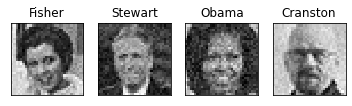

In [13]:
### enter Q4 answer here ###

# These faces should all look like their individual persons
# E.g. not the same

def create_weight_images(W):
    w_rs = np.reshape(W, (fx,fy,n_faces))
    fig = plt.figure()
    for i in range(n_faces):
        plt.subplot(1,4,i+1)

        plt.imshow(w_rs[:,:,i], cmap='gray', interpolation='none')
        plt.title(f"{fnames[i]}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

create_weight_images(W)

<hr>

<b>Q5.</b> Test your trained network. First, present each original image to the network (the four identities). Second, present a new noisy version (using the same level of noise used during training) of each of these images to the network. For each test image presented to the network, print out the correct answer and the answer produced by the network (winner-take-all).

Try creating a new set of four test images (one for each identity) with a higher level of noise that used during training that causes the network to make classification errors.

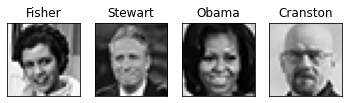

In [14]:
### enter Q5 answer here ###

face = [fisher, stewart, obama, cranston]
fnames = ['Fisher', 'Stewart', 'Obama', 'Cranston']
n_faces = len(face)
(fx, fy) = fisher.shape
flen = fx*fy

# view the four faces
for i in range(n_faces):
    plt.subplot(1, 4, i+1)
    plt.imshow(face[i], 'gray')
    plt.tick_params(axis='both', which='both',
                    bottom=False, top=False, labelbottom=False, 
                    right=False, left=False, labelleft=False)  
    plt.title(fnames[i])
plt.show()

In [15]:
def verify_tests(n_faces, pats, W):
    test_names = fnames
    test_run = [0] * n_faces
    winner = [0] * n_faces
    
    for idx in range(pats.shape[0]):
        face = pats[idx, :]
        test_run[idx] = np.array(np.matmul(face,W))
        winner[idx] = list(test_run[idx]).index(max(test_run[idx]))
        winner[idx] = fnames[winner[idx]]
        print(f"Correct Solution: {fnames[idx]}")
        print(test_run[idx])
        print(f"Network Solution: {winner[idx]}")
        print("")
        
verify_tests(n_faces, pats, W)

Correct Solution: Fisher
[ 0.95602379 -0.25528857 -0.06157161 -0.07698444]
Network Solution: Fisher

Correct Solution: Stewart
[-0.30602402  0.90735214  0.51218424 -0.61913123]
Network Solution: Stewart

Correct Solution: Obama
[-0.19071397  0.42968897  0.86310347 -0.56799451]
Network Solution: Obama

Correct Solution: Cranston
[ 0.055209   -0.46101438 -0.33789369  0.98206511]
Network Solution: Cranston



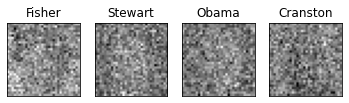

Correct Solution: Fisher
[ 0.3720188  -0.04115404  0.00919414 -0.05544709]
Network Solution: Fisher

Correct Solution: Stewart
[-0.0700531   0.34050784  0.19102116 -0.2455402 ]
Network Solution: Stewart

Correct Solution: Obama
[-0.19037644  0.154156    0.33751268 -0.24003774]
Network Solution: Obama

Correct Solution: Cranston
[ 0.00210276 -0.17979477 -0.17095963  0.39562984]
Network Solution: Cranston



In [16]:
# amount of noise, width (e.g. std) of the normal distribution of noise added
noise_scale_test1 = 0.07
# preallocate training pattern array
test_pats1 = np.zeros([n_faces, flen]) #e.g. 4 x 1024

idx = 0
# create noisy training patterns
# For each of the 500 variations, we will do the 4 faces we have
for i in range(n_faces):
    # normal noise with 0 mean and stdev of 1, multiplied by noise_scale (0.07 std)
    unit_noise1 = r.randn(flen)*noise_scale_test1
    # add face with noise to produce training data
    test_pats1[idx, :] = pats[i, :] + unit_noise1
    # normalize activation to unit length
    test_pats1[idx, :] = test_pats1[idx, :] / np.linalg.norm(test_pats1[idx, :])
    idx += 1
        
# view the four faces
for i in range(n_faces):
    plt.subplot(1, 4, i+1)
    plt.imshow(test_pats1[i].reshape(32,32), 'gray')
    plt.tick_params(axis='both', which='both',
                    bottom=False, top=False, labelbottom=False, 
                    right=False, left=False, labelleft=False)  
    plt.title(fnames[i])
plt.show()
        
verify_tests(n_faces, test_pats1, W)

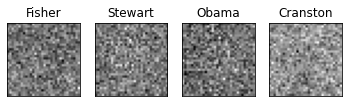

Correct Solution: Fisher
[ 0.18851419 -0.01144945 -0.02494155  0.00302898]
Network Solution: Fisher

Correct Solution: Stewart
[-0.09697404  0.17348726  0.10784152 -0.15601408]
Network Solution: Stewart

Correct Solution: Obama
[-0.06120926  0.09766188  0.18730362 -0.11505451]
Network Solution: Obama

Correct Solution: Cranston
[ 0.01212468 -0.11838219 -0.07187887  0.22526416]
Network Solution: Cranston



In [17]:
# amount of noise, width (e.g. std) of the normal distribution of noise added
noise_scale_test2 = 0.14
# preallocate training pattern array
test_pats2 = np.zeros([n_faces, flen]) #e.g. 4 x 1024

idx = 0
# create noisy training patterns
# For each of the 500 variations, we will do the 4 faces we have
for i in range(n_faces):
    # normal noise with 0 mean and stdev of 1, multiplied by noise_scale (0.07 std)
    unit_noise2 = r.randn(flen)*noise_scale_test2
    # add face with noise to produce training data
    test_pats2[idx, :] = pats[i, :] + unit_noise2
    # normalize activation to unit length
    test_pats2[idx, :] = test_pats2[idx, :] / np.linalg.norm(test_pats2[idx, :])
    idx += 1
    
# view the four faces
for i in range(n_faces):
    plt.subplot(1, 4, i+1)
    plt.imshow(test_pats2[i].reshape(32,32), 'gray')
    plt.tick_params(axis='both', which='both',
                    bottom=False, top=False, labelbottom=False, 
                    right=False, left=False, labelleft=False)  
    plt.title(fnames[i])
plt.show()

verify_tests(n_faces, test_pats2, W)

<hr>

<b>EXTRA CREDIT (2 point)</b>

See what happens when you change the coding for the output units from what was assumed above (the output of the correct answer equal to 1 and of the incorrect answers equal to 0) to a different coding of output units, with the output of the correct answer equal to 1 and the incorrect answers equal to -1). Retrain the network (like Q3), visualize the weights (like Q4), and test the network (like Q5).

Why does the visualization of the weights look different with this coding of output units from the one used in the main of the assignment? What is different about what is learned (and hence represented in the weights in the network) between the two ways of coding outputs? Add your written responses to a markdown cell in your assignment (an explanation is required to receive full extra credit).


In [18]:
### enter extra credit answer here ###

# Instead of using one-hot (0s and 1s), use -1 and 1

### enter Q1 answer here ###
# Changing scheme from 0, 1 to -1, 1
train_outs = np.zeros((n_train*n_faces, n_faces))
train_outs -= 1

for i in range(n_train*n_faces):
    train_outs[i,i%4] = 1

In [19]:
### enter Q2 answer here ###

# Note: assume linear activation function
rng = np.random.default_rng(12345)
W = rng.random((fx*fy, n_faces))  # 1024, 4 (e.g. inputs, outputs)

for k in range(n_faces):
        W[:, k] = W[:, k] / np.linalg.norm(W[:, k])

In [20]:
### enter Q3 answer here ###
# Have to do this by hand, cannot do this via keras/tf
# Step through all of the weights and adjust them as you go
# Do all the weight updates first for a given pattern
# oj is the teacher that is clamped onto the output
# You CANNOT do Hebbian learning with Keras/Tensorflow. 
# You need to implement Oja's rule (Hebbian learning + weight normalization) using basic Python code. 

lr = 0.01

for i in range(n_train*n_faces):
    for j in range(fx*fy):  # Num pixels
        for k in range(n_faces):  # Num faces
            dw = lr*train_pats[i,j]*train_outs[i,k]
            # The rule given in the slides for Oja's Rule
            # dwij = lr*(ii*oj-oj**2*wij)
            # dw = lr * (train_pats[i,j]*train_outs[i,k] - W[j,k]*train_outs[i,k]**2)
            W[j,k] += dw
            
    # Oja's Rule: Normalize before the next pattern is presented
    # Normalize the weights
    # normalize activation to unit length
    for k in range(n_faces):
        W[:, k] = W[:, k] / np.linalg.norm(W[:, k])

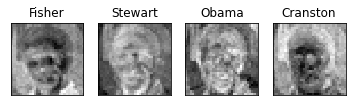

In [21]:
### enter Q4 answer here ###

# These faces should all look like their individual persons
# E.g. not the same

def create_weight_images(W):
    w_rs = np.reshape(W, (fx,fy,n_faces))
    fig = plt.figure()
    for i in range(n_faces):
        plt.subplot(1,4,i+1)

        plt.imshow(w_rs[:,:,i], cmap='gray', interpolation='none')
        plt.title(f"{fnames[i]}")
        plt.xticks([])
        plt.yticks([])
    plt.show()

create_weight_images(W)

In [22]:
print("Original Images:")
verify_tests(n_faces, pats, W)
print("---------------------------------------")
print("")
print("Original Training Images:")
verify_tests(n_faces, test_pats1, W)
print("---------------------------------------")
print("")
print("Training Images With Double the Noise:")
verify_tests(n_faces, test_pats2, W)

Original Images:
Correct Solution: Fisher
[ 0.65595134 -0.6251067  -0.55125555 -0.31095078]
Network Solution: Fisher

Correct Solution: Stewart
[-0.63952627  0.6175536   0.23721444 -0.75628722]
Network Solution: Stewart

Correct Solution: Obama
[-0.61201116  0.05855142  0.549162   -0.78882109]
Network Solution: Obama

Correct Solution: Cranston
[ 0.01896941 -0.55488934 -0.53877766  0.80259745]
Network Solution: Cranston

---------------------------------------

Original Training Images:
Correct Solution: Fisher
[ 0.23127314 -0.21115622 -0.22205717 -0.16057856]
Network Solution: Fisher

Correct Solution: Stewart
[-0.19715731  0.22251541  0.08323649 -0.29692922]
Network Solution: Stewart

Correct Solution: Obama
[-0.29446895  0.08377857  0.31567456 -0.28342909]
Network Solution: Obama

Correct Solution: Cranston
[ 0.01625374 -0.1900587  -0.22492766  0.34614188]
Network Solution: Cranston

---------------------------------------

Training Images With Double the Noise:
Correct Solution: Fi

## Question:
Why does the visualization of the weights look different with this coding of output units from the one used in the main of the assignment? What is different about what is learned (and hence represented in the weights in the network) between the two ways of coding outputs? Add your written responses to a markdown cell in your assignment (an explanation is required to receive full extra credit).

## Written Explanation:
In this coding scheme, the network is actively penalized for guessing wrong, whereas before there was no penalty.  Specifically, in the previous network, the weights were multiplied by 0 (due to the 0 to 1 discrete variables) and thus did not matter: in the new network, these weights do have an effect since they are now multiplied by -1.  Namely, the error is continuously driven down since even if the network is correct, having high probabilities for other faces will actively make the network "lose points".  <br>

Thus, for instance, previously the HW network could have high weight values for the generic head shape and facial structure that would be applicable to everyone; here, the extra credit network can no longer do this, since having very high weights for information __that does not help it distinguish between the individuals__ is actively going to make it lose points. <br>

What we observe in the weight matrices then, is that features that do not contain __useful information for distinuishing between faces__ is heavily discounted, because __the network does not benefit from information that can be applied to all faces__ as it will get penalized for identifying and positively weighting those features.  Specifically, there is clearly more black represented in the images, which represents lower weights.  <br>

The main difference between what is learned is that for the original network (the HW), this network will be much more lenient in identifying generally useful information (e.g. the location of eyes, the contour of the head, etc) whereas the extra credit network will learn much more specific features (e.g. the tilt of the face in the image, the amount of space filled by the head, etc.).  The result of this is that it should be expected that the extra credit network performs much better than the HW network (in terms of being "confident" about its answer), but the cost is that since the extra credit network looks for more specific features, it may not generalize as well (e.g. if there's an image where the individual has a different hair style or the view is of different orientation, the extra credit network will likely perform worse since it may have over-fit to the specific features present in the training images).